In [4]:
# 패키지 불러오기
require(ggplot2)
#require(dplyr)
require(repr)
options(repr.plot.width=10, repr.plot.height=3)

Loading required package: ggplot2
Loading required package: repr


In [5]:
# 삭제
rm(list = ls())

In [121]:
# Smith-Wilson Class (S4) 정의
setClass('Smith.Wilson',
        representation(alpha="numeric", UFR="numeric", terms="numeric", int="numeric", zeta="numeric"))

# Wilson function 메소드 정의
setGeneric("Wilson", function(object, ...) standardGeneric("Wilson"))
setMethod("Wilson", "Smith.Wilson", function(object,t,u){
    y <- 1/(1+object@UFR)^(t+u)*(object@alpha*pmin(t,u) - 0.5*exp(-object@alpha*pmax(t,u))*(exp(object@alpha*pmin(t,u)) - exp(-object@alpha*pmin(t,u))))
    return(y)
})
    
# 금리 보정 결과 메소드
setGeneric("swCurve", function(object, ...) standardGeneric("swCurve"))
setMethod("swCurve", "Smith.Wilson", function(object, t){
    p <- 1/(1+object@UFR)^t + object@zeta %*% Wilson(object,t,object@terms)
    y <- (1/p)^(1/t) - 1
    return(y)
})

# 객체 초기화
setMethod("initialize", "Smith.Wilson", function(.Object, alpha, UFR, terms, int){
    .Object@alpha <- alpha
    .Object@UFR <- UFR
    .Object@terms <- terms
    .Object@int <- int
    
    W <- outer(terms, terms, FUN=function(x,y) Wilson(.Object, x, y))
    m  <- 1/(1+int)^terms
    mu <- 1/(1+UFR)^terms
    .Object@zeta <- as.numeric((m-mu)%*%solve(W))
    
    return(.Object)
})

[1] "Wilson"

[1] "Wilson"

[1] "swCurve"

[1] "swCurve"

[1] "initialize"

In [122]:
# 입력 데이터
int.rate <- c(0.0187, 0.0209, 0.0215, 0.0231, 0.0238, 0.0244, 0.0246, 0.0244)
maturity <- c(1,2,3,4,5,7,10,20)

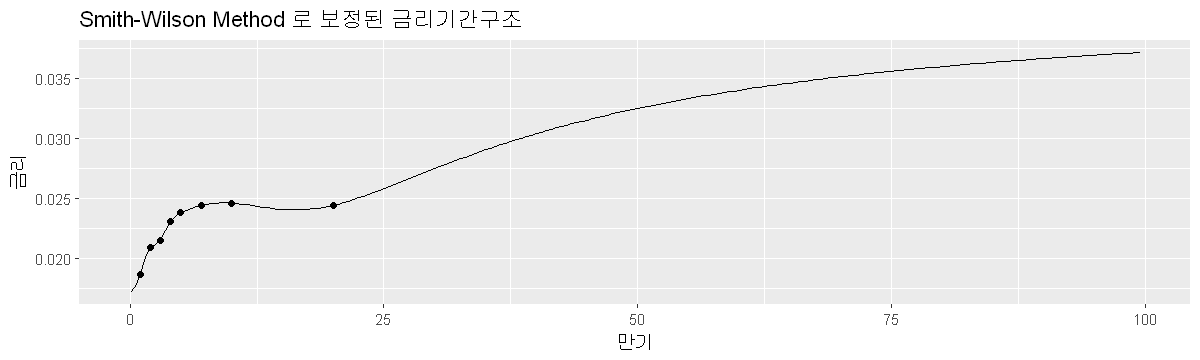

In [213]:
# Smith-Wilson 객체 생성
sw <- new("Smith.Wilson", alpha=0.1, UFR=0.042, terms=maturity, int=int.rate)

# 보정된 금리 생성
t <- seq(0.01,100,by=0.5)
int.rate.sw <- sapply(t, FUN=function(t) swCurve(sw, t))
    
# 그래프 출력
ggplot() +
    geom_line(aes(x=t, y=int.rate.sw)) +
    geom_point(aes(x=maturity, y=int.rate)) +
    labs(x='만기', y='금리', title='Smith-Wilson Method 로 보정된 금리기간구조')

In [211]:
error <- function(alpha){
    sw@alpha <- alpha
    error <- abs(0.0001 - abs(swCurve(sw, 60) - UFR))
    return(error)
}

optimize(error, interval=c(0,1), maximum=FALSE)

7.71773e-07


In [77]:
# 입력 데이터
int.rate <- c(0.0187, 0.0209, 0.0215, 0.0231, 0.0238, 0.0244, 0.0246, 0.0244)
mat <- c(1,2,3,4,5,7,10,20)

#1. Wilson Function
wilson <- function(t,u, UFR=0.042, alpha=0.1) (1/(1+UFR)^(t+u))*(alpha*pmin(t,u) - 0.5*exp(-alpha*pmax(t,u))*(exp(alpha*pmin(t,u)) - exp(-alpha*pmin(t,u))))

#1-1. Weight
weight <- function(obs.mat, proj.mat, UFR=0.042, alpha=0.1) outer(obs.mat, proj.mat, FUN=function(x,y) wilson(x,y,UFR=UFR,alpha=alpha))

#1.2. Bond Price
bond.price <- function(int.rate, mat) 1/(1+int.rate)^mat
 
#1.3. Loss Function
tmp <- function(bond.price, mat, UFR) bond.price - 1/(1+UFR)^mat